In [1]:
import eland as ed
import numpy as np
import matplotlib.pyplot as plt
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv

os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [3]:
%%capture
ticker = "NVDA"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_obv = ed.eland_to_pandas(df_eod).sort_values(by='date_reference', ascending=True).tail(100).set_index(
    'date_reference')

In [4]:
# Calculate daily close change
df_obv['prev_close'] = df_obv['val_close'].shift(1)
df_obv['close_change'] = df_obv['val_close'] - df_obv['prev_close']

# Calculate signed volume: +volume if up, -volume if down, 0 if flat
df_obv['signed_volume'] = np.where(
    df_obv['close_change'] > 0, df_obv['val_volume'],
    np.where(df_obv['close_change'] < 0, -df_obv['val_volume'], 0)
)

# Calculate OBV (cumulative sum of signed volume)
df_obv['obv'] = df_obv['signed_volume'].cumsum()

# Drop NaN rows (initial prev_close is NaN)
df_obv.dropna(inplace=True)

,key_ticker,val_close,val_high,val_low,val_open,val_volume,prev_close,close_change,signed_volume,obv,obv_change,position,returns,strategy
date_reference,,,,,,,,,,,,,,
2025-10-20,IBM,283.65,285.5000,280.9600,281.25,3494336,281.28,2.37,3494336,28208754,3494336.0,1,0.008390,0.008390
2025-10-21,IBM,282.05,285.3100,281.6000,283.31,4080981,283.65,-1.60,-4080981,24127773,-4080981.0,-1,-0.005657,-0.005657
2025-10-22,IBM,287.51,289.1700,281.3500,281.99,10538480,282.05,5.46,10538480,34666253,10538480.0,1,0.019173,-0.019173
2025-10-23,IBM,285.00,285.5791,263.5623,264.95,16676394,287.51,-2.51,-16676394,17989859,-16676394.0,-1,-0.008768,-0.008768
2025-10-24,IBM,307.46,310.7500,282.2100,283.77,16914243,285.00,22.46,16914243,34904102,16914243.0,1,0.075856,-0.075856


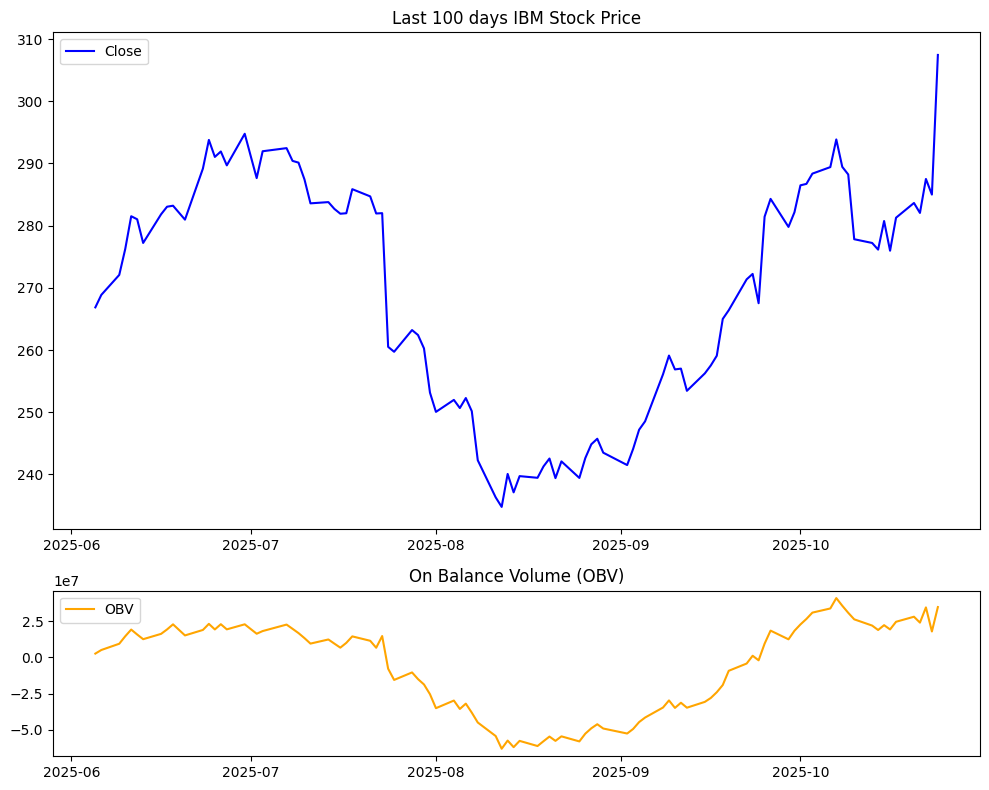

In [5]:
df_obv.tail()

<Axes: title={'center': 'Market Positioning'}, xlabel='date_reference'>

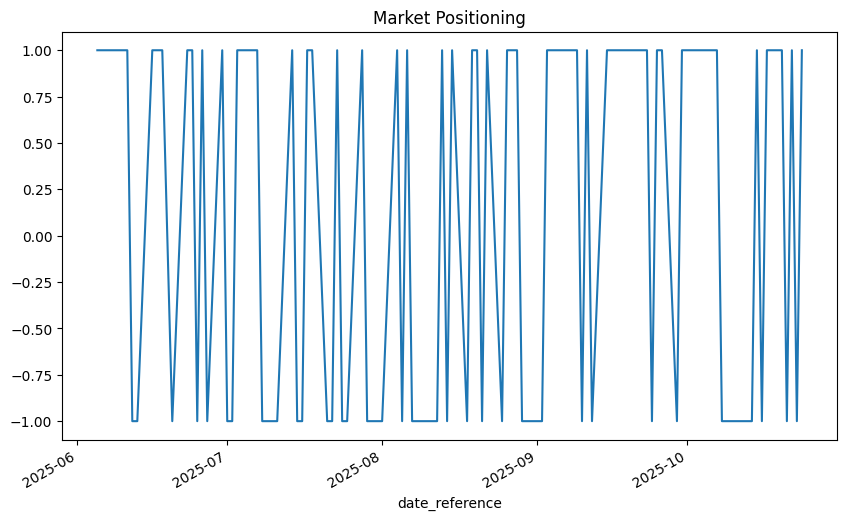

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

# Top: Price plot
axs[0].plot(df_obv.index, df_obv['val_close'], label='Close', color='blue')
axs[0].set_title(f"Last 100 days {ticker} Stock Price")
axs[0].legend()

# Bottom: OBV plot
axs[1].plot(df_obv.index, df_obv['obv'], label='OBV', color='orange')
axs[1].set_title('On Balance Volume (OBV)')
axs[1].legend()

plt.tight_layout()
plt.show()

In [7]:
# Generate positions for the strategy (1 for up OBV, -1 for down, 0 flat)
df_obv['obv_change'] = df_obv['obv'].diff()
df_obv['position'] = np.where(df_obv['obv_change'] > 0, 1, np.where(df_obv['obv_change'] < 0, -1, 0))
df_obv['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

returns     1.157954
strategy    0.846447
dtype: float64

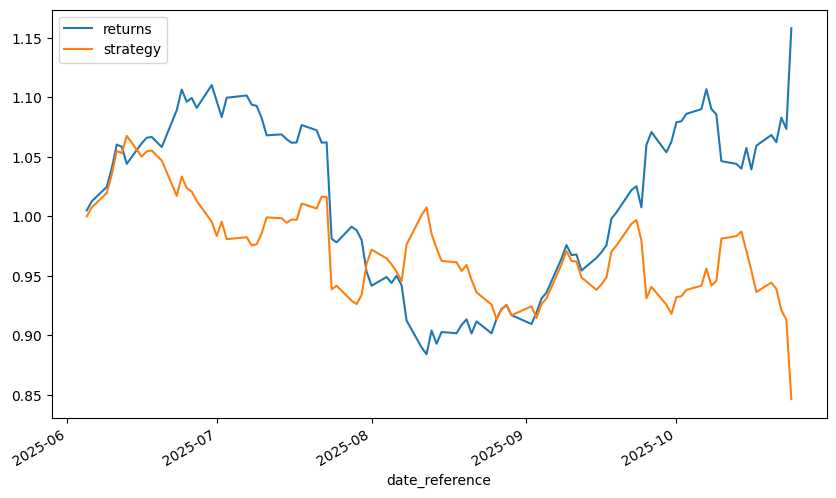

In [8]:
df_obv['returns'] = np.log(df_obv['val_close'] / df_obv['val_close'].shift(1))
df_obv['strategy'] = df_obv['position'].shift(1) * df_obv['returns']
df_obv[['returns', 'strategy']].sum().apply(np.exp)

In [9]:
df_obv[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));

,val_close,obv_change,position
date_reference,,,
2025-06-12,281.03,-3418007.0,-1
2025-06-16,281.83,3685321.0,1
2025-06-20,280.97,-7676962.0,-1
2025-06-23,289.18,3786159.0,1
2025-06-25,291.06,-3862309.0,-1
2025-06-26,291.93,3621110.0,1
2025-06-27,289.70,-3562501.0,-1
2025-06-30,294.78,3495386.0,1
2025-07-01,291.20,-3272797.0,-1
